In [12]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
RESULTS_DIR = "../results/movielens_tuning_deepfm"

In [3]:
p = Path(RESULTS_DIR)

In [4]:
pickle_paths = p.glob("./*.pickle")

In [5]:
pickle_paths = list(pickle_paths)

In [6]:
len(pickle_paths)

2304

In [10]:
json_paths = p.glob("./*.json")
json_paths = list(json_paths)

In [22]:
all_rewards = []
for i, p in enumerate(json_paths):
    with open(p, "r") as f:
        d = json.load(f)
    mean_reward = d[0][1]['Total reward mean']
    all_rewards.append((p, mean_reward))

In [26]:
sorted_rewards = sorted(all_rewards, key=lambda x: x[1], reverse=True)

In [27]:
best_j_paths = [x[0] for x in sorted_rewards[:5]]

In [28]:
best_j_paths

[PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_395_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_789_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_1158_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_1616_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_774_t_30000_n_3_d_15.json')]

In [29]:
worst_j_paths = [x[0] for x in sorted_rewards[-5:]]

In [30]:
worst_j_paths

[PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_2090_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_1694_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_2092_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_514_t_30000_n_3_d_15.json'),
 PosixPath('../results/movielens_tuning_deepfm/results_movielens_config_706_t_30000_n_3_d_15.json')]

In [33]:
import itertools
all_j_paths = list(itertools.chain(best_j_paths, worst_j_paths))

In [38]:
all_pickle_paths = [Path(str(x).split('.json')[0]+'.pickle') for x in all_j_paths]


In [51]:
str(all_pickle_paths[0]).split('config_')[1].split('_t')[0]

'395'

In [54]:
reward_dict = {}
ndcg_dict = {}
time_dict = {}
for i, p in enumerate(all_pickle_paths):
    ind = str(p).split('config_')[1].split('_t')[0]
    with open(p, "rb") as f:
        d = pickle.load(f)
    stats_dict = d[0][0]
    one_rew_dict = d[1]
    one_ndcg_dict = d[2]
    for key_raw in one_rew_dict:
        rew_list = one_rew_dict[key_raw]
        ndcg_list = one_ndcg_dict[key_raw]
        mean_rew = np.mean(np.stack(rew_list), axis=0)
        mean_ndcg = np.mean(np.stack(ndcg_list), axis=0)

        key = key_raw + ' ' + str(ind)
        reward_dict[key] = mean_rew
        ndcg_dict[key] = mean_ndcg
#         assert key == stats_dict[0]
        time_dict[key] = stats_dict[1]['Time mean']

In [55]:
reward_dict

{'DeepFM 395': array([[0.00000000e+00],
        [0.00000000e+00],
        [3.33333333e-01],
        ...,
        [1.08573333e+04],
        [1.08576667e+04],
        [1.08580000e+04]]),
 'DeepFM 789': array([[6.66666667e-01],
        [6.66666667e-01],
        [6.66666667e-01],
        ...,
        [1.07060000e+04],
        [1.07063333e+04],
        [1.07066667e+04]]),
 'DeepFM 1158': array([[3.33333333e-01],
        [3.33333333e-01],
        [3.33333333e-01],
        ...,
        [1.01446667e+04],
        [1.01446667e+04],
        [1.01446667e+04]]),
 'DeepFM 1616': array([[0.00000000e+00],
        [0.00000000e+00],
        [3.33333333e-01],
        ...,
        [1.00963333e+04],
        [1.00963333e+04],
        [1.00963333e+04]]),
 'DeepFM 774': array([[3.33333333e-01],
        [3.33333333e-01],
        [3.33333333e-01],
        ...,
        [9.75766667e+03],
        [9.75766667e+03],
        [9.75766667e+03]]),
 'DeepFM 2090': array([[3.33333333e-01],
        [3.33333333e-01],
      

In [56]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

## Plot the results

In [57]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    plt.savefig(f'movielens_results_ndcg', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

In [58]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
        else:
            to_plot = rewards
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    
    plot_name = 'ctr' if plot_type == "CTR" else 'reward'
    plt.savefig(f'movielens_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

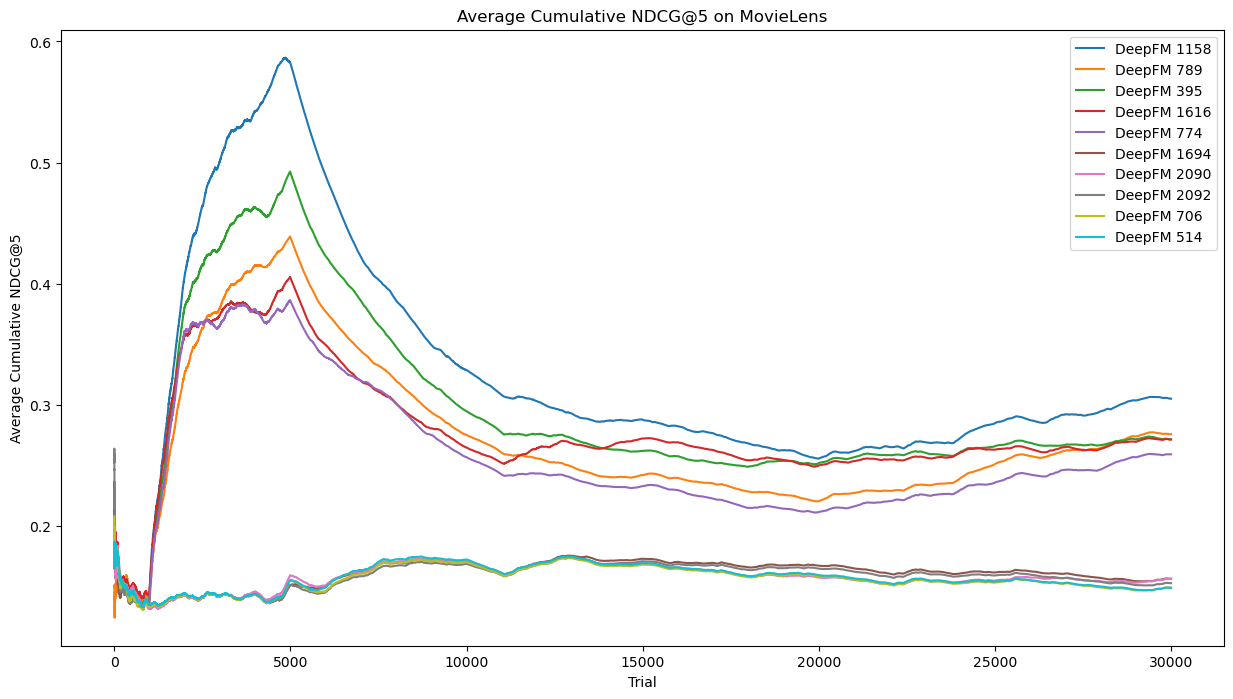

In [59]:
plot_ndcg(ndcg_dict)

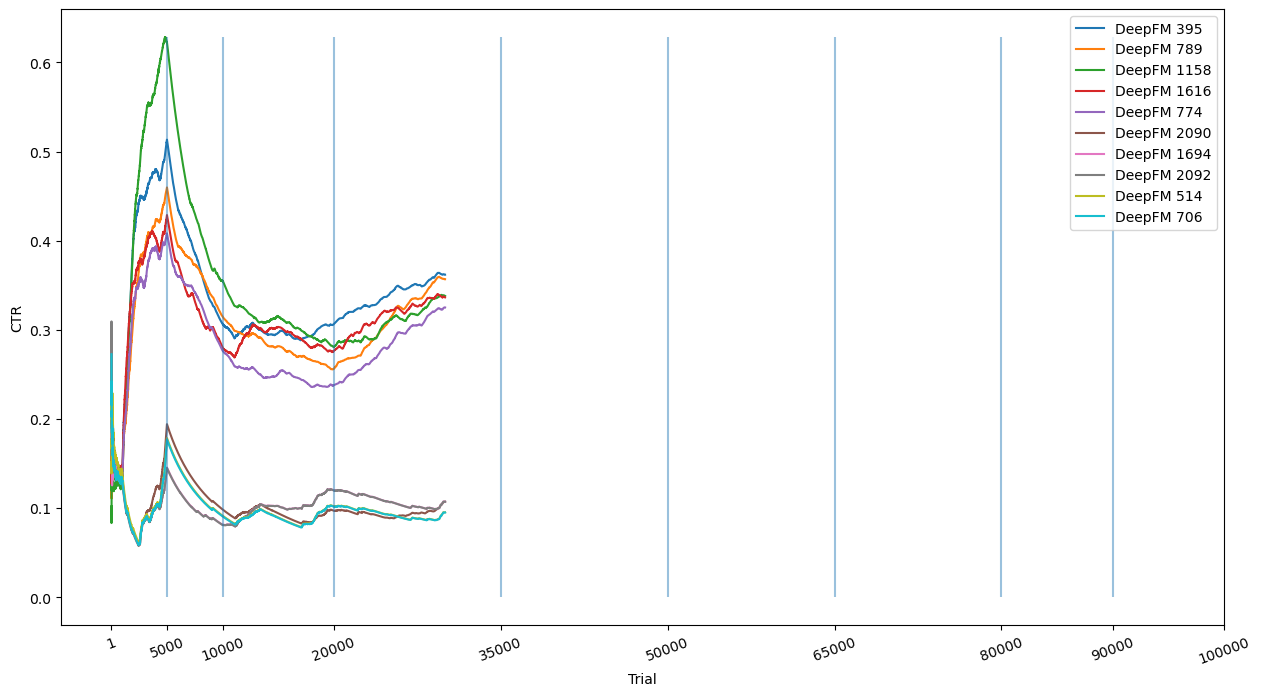

In [60]:
plot_ctrs_or_rewards(reward_dict, "CTR", CHANGE_POINTS);

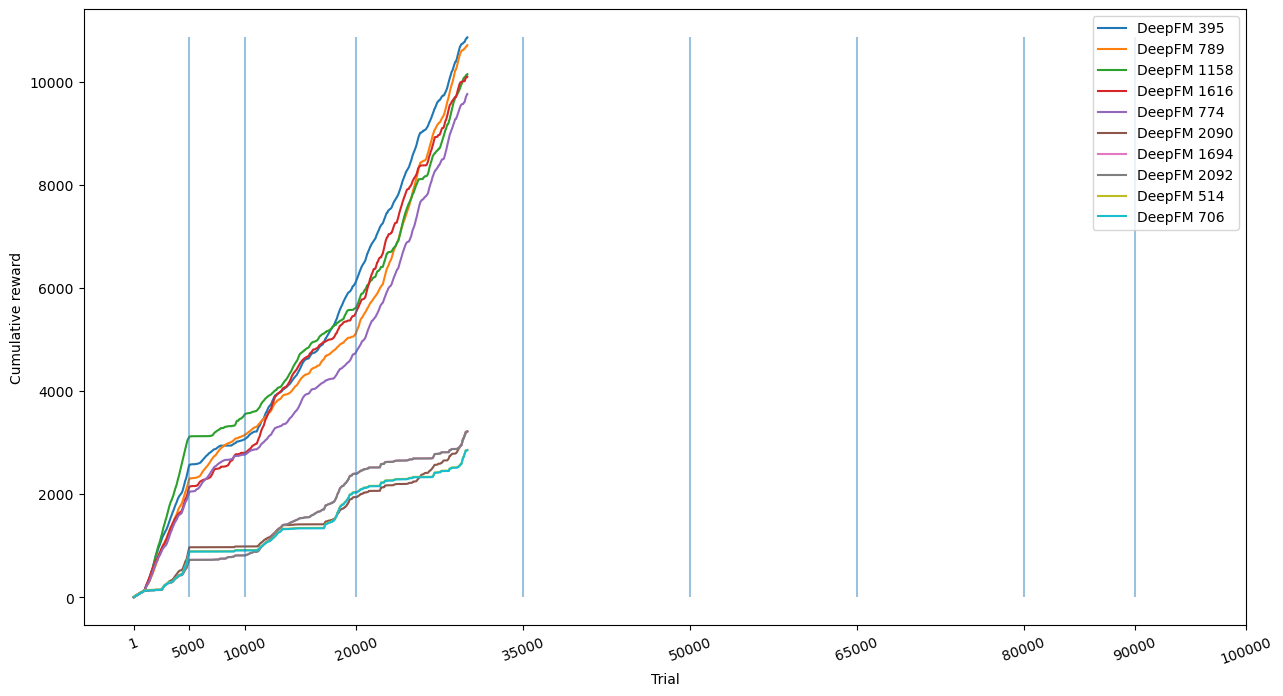

In [61]:
plot_ctrs_or_rewards(reward_dict, "Cumulative reward", CHANGE_POINTS);

In [62]:
print('Time')
{k: round(v,1) for k, v in time_dict.items()}

Time


{'DeepFM 395': 651.6,
 'DeepFM 789': 633.8,
 'DeepFM 1158': 659.2,
 'DeepFM 1616': 612.3,
 'DeepFM 774': 686.3,
 'DeepFM 2090': 634.5,
 'DeepFM 1694': 567.2,
 'DeepFM 2092': 642.2,
 'DeepFM 514': 655.3,
 'DeepFM 706': 631.5}

In [63]:
print('Reward')
[(k,v[-1][0]) for k,v in reward_dict.items()]

Reward


[('DeepFM 395', 10858.0),
 ('DeepFM 789', 10706.666666666666),
 ('DeepFM 1158', 10144.666666666666),
 ('DeepFM 1616', 10096.333333333334),
 ('DeepFM 774', 9757.666666666666),
 ('DeepFM 2090', 3220.0),
 ('DeepFM 1694', 3219.0),
 ('DeepFM 2092', 3216.3333333333335),
 ('DeepFM 514', 2860.6666666666665),
 ('DeepFM 706', 2853.3333333333335)]

In [64]:
print('NDCG')
[(k, round(v[-1][0],1)) for k,v in ndcg_dict.items()]

NDCG


[('DeepFM 395', 8145.7),
 ('DeepFM 789', 8274.0),
 ('DeepFM 1158', 9153.1),
 ('DeepFM 1616', 8143.8),
 ('DeepFM 774', 7777.3),
 ('DeepFM 2090', 4690.5),
 ('DeepFM 1694', 4696.8),
 ('DeepFM 2092', 4586.5),
 ('DeepFM 514', 4469.6),
 ('DeepFM 706', 4478.0)]

In [65]:
reward_dict

{'DeepFM 395': array([[0.00000000e+00],
        [0.00000000e+00],
        [3.33333333e-01],
        ...,
        [1.08573333e+04],
        [1.08576667e+04],
        [1.08580000e+04]]),
 'DeepFM 789': array([[6.66666667e-01],
        [6.66666667e-01],
        [6.66666667e-01],
        ...,
        [1.07060000e+04],
        [1.07063333e+04],
        [1.07066667e+04]]),
 'DeepFM 1158': array([[3.33333333e-01],
        [3.33333333e-01],
        [3.33333333e-01],
        ...,
        [1.01446667e+04],
        [1.01446667e+04],
        [1.01446667e+04]]),
 'DeepFM 1616': array([[0.00000000e+00],
        [0.00000000e+00],
        [3.33333333e-01],
        ...,
        [1.00963333e+04],
        [1.00963333e+04],
        [1.00963333e+04]]),
 'DeepFM 774': array([[3.33333333e-01],
        [3.33333333e-01],
        [3.33333333e-01],
        ...,
        [9.75766667e+03],
        [9.75766667e+03],
        [9.75766667e+03]]),
 'DeepFM 2090': array([[3.33333333e-01],
        [3.33333333e-01],
      

In [66]:
reward_dict['LinearTS (nu=0.3)'][-1][0]

KeyError: 'LinearTS (nu=0.3)'

In [ ]:
reward_dict['DeepFM (batch_size=1000)'][-1][0]

In [ ]:
18 55347.4

## Old table